In [58]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix   
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Diabetes dataset for regression or classification: 
# The goal of the script is to first classify if a patient 
# has diabetes or not based on multiple features like:
#   Patient age
#   Patient sex
#   Patient BMI
#   Patient average blood pressure
#   Six blood serum measurements
# All of these features are measured on 442 patients, and used
# as an indicator of disease progression after one year.

# First we load the dataset
# Here we see that the "x" value represents each person and their
# 10 features. While the "y" values represents each person.
# The diabetes dataset is returned as a "regression" dataset
data = load_diabetes()
x, y = data['data'], data['target']
print(data["feature_names"])
print(x.shape)
print(y.shape)
print(x[0][0])

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
(442, 10)
(442,)
0.0380759064334241


In [59]:
x_train_normal, x_test_normal, y_train_normal, y_test_normal = train_test_split(x, y, test_size=0.2, random_state=42)

# Since the diabetes dataset is loaded as a regression dataset,
# we have to convert it to a classification problem.

# First we create an array of zeros with the same size as "y"
# Then we set each element to 1 in our "y_" array, where in the "y" array
# the correspoding element is bigger than 140. Then we convert the values
# of decimals in "y_" to integers.
y_ = np.zeros(y.shape)
y_[y > 140] = 1.
y_ = y_.astype(int)

# Then we split our data into 80% training data and 20% testing data
# The "random_state" parameter is used for reprodruction of the data. 
# The stratify parameter makes sure that "y_" is equally represented 
# in both training and test. This type of setup is called holdout.
x_train_labeled, x_test_labeled, y_train_labaled, y_test_labaled = train_test_split(x, y_, test_size=0.2, random_state=42, stratify=y_)

In [60]:
# Standardise the data so that all the data has a range between 0 and 1, 
# instead of between -1 and 1. This is to scale our features correctly.
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_train_standarized_labeled = min_max_scaler.fit_transform(x_train_labeled)
x_test_standarized_labeled = min_max_scaler.fit_transform(x_test_labeled)

NameError: name 'x_test_labeled' is not defined

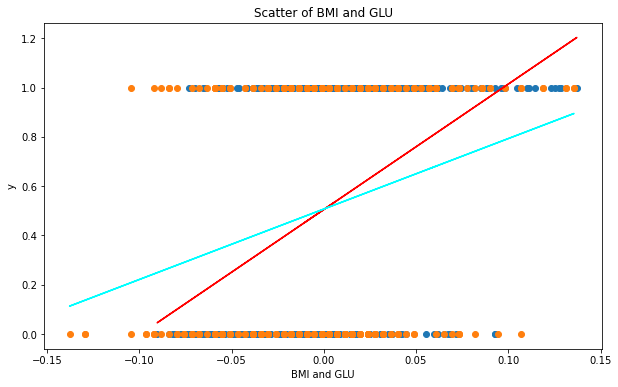

In [56]:
bmi = x_train_normal[:, np.newaxis, 2]
glu = x_train_normal[:, np.newaxis, 9]

y = y_train_normal[:, np.newaxis]

bmi_linear_regression = LinearRegression().fit(bmi, y_train_normal)
bmi_predicted_y = bmi_linear_regression.predict(bmi)

glu_linear_regression = LinearRegression().fit(glu, y_train_normal)
glu_predicted_y = glu_linear_regression.predict(glu)

# Plotting of the regression line on a scatterd plot
plt.figure(figsize=(10,6))
plt.scatter(bmi, y_train_normal)
plt.scatter(glu, y_train_normal)
plt.plot(bmi, bmi_predicted_y, c='r')
plt.plot(glu, glu_predicted_y, c='cyan')
plt.title('Scatter of BMI and GLU')
plt.ylabel('y')
plt.xlabel('BMI and GLU')
plt.show()